In [2]:
import xml.etree.ElementTree as ET

tree = ET.parse('/kaggle/input/absa-dataset/train.xml')
root = tree.getroot()

data = []
for sentence in root.findall('sentence'):
    text = sentence.find('text').text
    aspects = sentence.find('aspectCategories')
    if aspects is not None:
        for aspect in aspects.findall('aspectCategory'):
            category = aspect.get('category')
            polarity = aspect.get('polarity')
            data.append({
                'text': text,
                'aspect': category,
                'polarity': polarity
            })

In [2]:
data[:5]

[{'text': "It might be the best sit down food I've had in the area, so if you are going to the upright citizen brigade, or the garden, it could be just the place for you.",
  'aspect': 'food',
  'polarity': 'positive'},
 {'text': "It might be the best sit down food I've had in the area, so if you are going to the upright citizen brigade, or the garden, it could be just the place for you.",
  'aspect': 'place',
  'polarity': 'neutral'},
 {'text': 'Hostess was extremely accommodating when we arrived an hour early for our reservation.',
  'aspect': 'staff',
  'polarity': 'positive'},
 {'text': 'Hostess was extremely accommodating when we arrived an hour early for our reservation.',
  'aspect': 'miscellaneous',
  'polarity': 'neutral'},
 {'text': "We were a couple of minutes late for our reservation and minus one guest, but we didn't think we deserved the attitude we got from the hostess.",
  'aspect': 'miscellaneous',
  'polarity': 'neutral'}]

In [6]:
len(data)

7090

In [3]:
sentence_lengths = [len(item['text'].split()) for item in data]

Mean sentence length: 24.142736248236954
Minimum sentence length: 4
Maximum sentence length: 67


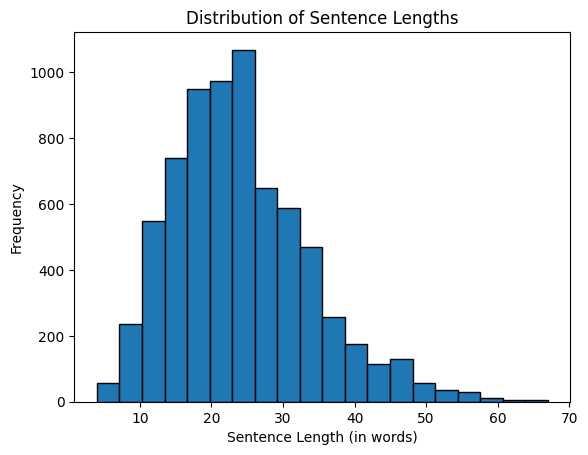

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate statistics
mean_length = np.mean(sentence_lengths)
min_length = np.min(sentence_lengths)
max_length = np.max(sentence_lengths)

print(f"Mean sentence length: {mean_length}")
print(f"Minimum sentence length: {min_length}")
print(f"Maximum sentence length: {max_length}")

# Plot the distribution of sentence lengths
plt.hist(sentence_lengths, bins=20, edgecolor='black')
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Sentence Length (in words)")
plt.ylabel("Frequency")
plt.show()

In [7]:
from transformers import T5Tokenizer
from torch.utils.data import Dataset, DataLoader

tokenizer = T5Tokenizer.from_pretrained('t5-small')

class ABSADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_text = f"aspect: {item['aspect']} context: {item['text']}"
        target_text = item['polarity']
        
        inputs = self.tokenizer(input_text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")
        targets = self.tokenizer(target_text, max_length=self.max_length, padding='max_length', truncation=True, return_tensors="pt")

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": targets["input_ids"].squeeze()
        }

# Create the dataset and dataloader
train_dataset = ABSADataset(data, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [19]:
data_fake = data[:10]
train_dataset_fake = ABSADataset(data_fake, tokenizer)
train_dataloader_fake = DataLoader(train_dataset_fake, batch_size=4, shuffle=True)

In [4]:
import xml.etree.ElementTree as ET

# Parse the validation XML file
val_tree = ET.parse('/kaggle/input/absa-dataset/val.xml')
val_root = val_tree.getroot()

# Prepare validation data
val_data = []
for sentence in val_root.findall('sentence'):
    text = sentence.find('text').text
    aspects = sentence.find('aspectCategories')
    if aspects is not None:
        for aspect in aspects.findall('aspectCategory'):
            category = aspect.get('category')
            polarity = aspect.get('polarity')
            val_data.append({
                'text': text,
                'aspect': category,
                'polarity': polarity
            })

print(f"Number of validation samples: {len(val_data)}")

Number of validation samples: 888


In [5]:
# Create the validation dataset and dataloader
val_dataset = ABSADataset(val_data, tokenizer)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [20]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score

def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            # Generate predictions
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            
            all_preds.extend(preds.cpu().numpy().flatten())  # Flatten the preds array
            all_labels.extend(labels.cpu().numpy().flatten())  # Flatten the labels array

    avg_loss = total_loss / len(dataloader)
    
    # Convert lists to numpy arrays if needed
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Ensure the shapes and types are correct
    print(f"Shapes: labels={all_labels.shape}, preds={all_preds.shape}")
    print(f"Types: labels={type(all_labels)}, preds={type(all_preds)}")

    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy



In [16]:
train_dataloader

In [23]:
import torch
from transformers import T5ForConditionalGeneration, AdamW
from tqdm import tqdm
# Load the model
model = T5ForConditionalGeneration.from_pretrained('t5-small')
model.train()

# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_val_loss = float('inf')
for epoch in range(num_epochs):
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        optimizer.zero_grad()
        
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

#         print(f"Epoch: {epoch}, Loss: {loss.item()}")
    
    val_loss, val_accuracy = evaluate(model, val_dataloader)
    print(f"Epoch: {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save_pretrained('./best_absa_t5_model')
        tokenizer.save_pretrained('./best_absa_t5_tokenizer')
        print("Model saved!")

print(f"Best Validation Loss: {best_val_loss}")


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 1773/1773 [10:17<00:00,  2.87it/s]


Shapes: labels=(454656,), preds=(454656,)
Types: labels=<class 'numpy.ndarray'>, preds=<class 'numpy.ndarray'>
Epoch: 0, Validation Loss: 0.0030788336728431016, Validation Accuracy: 0.9988232861768018
Model saved!


Epoch 2/5: 100%|██████████| 1773/1773 [09:39<00:00,  3.06it/s]


Shapes: labels=(454656,), preds=(454656,)
Types: labels=<class 'numpy.ndarray'>, preds=<class 'numpy.ndarray'>
Epoch: 1, Validation Loss: 0.0017972775149738063, Validation Accuracy: 0.9992125914977478
Model saved!


Epoch 3/5: 100%|██████████| 1773/1773 [09:39<00:00,  3.06it/s]


Shapes: labels=(454656,), preds=(454656,)
Types: labels=<class 'numpy.ndarray'>, preds=<class 'numpy.ndarray'>
Epoch: 2, Validation Loss: 0.0015768289478466351, Validation Accuracy: 0.9993005701013513
Model saved!


Epoch 4/5: 100%|██████████| 1773/1773 [09:39<00:00,  3.06it/s]


Shapes: labels=(454656,), preds=(454656,)
Types: labels=<class 'numpy.ndarray'>, preds=<class 'numpy.ndarray'>
Epoch: 3, Validation Loss: 0.0014027873655101536, Validation Accuracy: 0.9993841497747747
Model saved!


Epoch 5/5: 100%|██████████| 1773/1773 [09:39<00:00,  3.06it/s]


Shapes: labels=(454656,), preds=(454656,)
Types: labels=<class 'numpy.ndarray'>, preds=<class 'numpy.ndarray'>
Epoch: 4, Validation Loss: 0.0013046222445916862, Validation Accuracy: 0.9994545326576577
Model saved!
Best Validation Loss: 0.0013046222445916862


In [24]:
import xml.etree.ElementTree as ET

tree = ET.parse('/kaggle/input/absa-dataset/test.xml')
root = tree.getroot()

test = []
for sentence in root.findall('sentence'):
    text = sentence.find('text').text
    aspects = sentence.find('aspectCategories')
    if aspects is not None:
        for aspect in aspects.findall('aspectCategory'):
            category = aspect.get('category')
            polarity = aspect.get('polarity')
            test.append({
                'text': text,
                'aspect': category,
                'polarity': polarity
            })

In [27]:
test[:5]

[{'text': 'We went again and sat at the bar this time, I had 5 pints of guinness and not one buy-back, I ordered a basket of onion rings and there were about 5 in the basket, the rest was filled with crumbs, the chili was not even edible.',
  'aspect': 'place',
  'polarity': 'neutral'},
 {'text': 'We went again and sat at the bar this time, I had 5 pints of guinness and not one buy-back, I ordered a basket of onion rings and there were about 5 in the basket, the rest was filled with crumbs, the chili was not even edible.',
  'aspect': 'food',
  'polarity': 'negative'},
 {'text': "The food was good, but it's not worth the wait--or the lousy service.",
  'aspect': 'food',
  'polarity': 'positive'},
 {'text': "The food was good, but it's not worth the wait--or the lousy service.",
  'aspect': 'service',
  'polarity': 'negative'},
 {'text': "Waiter took our drink order and then we didn't see him for 15 minutes.",
  'aspect': 'staff',
  'polarity': 'negative'}]

In [28]:
test_dataset = ABSADataset(test, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)
test_loss, test_accuracy = evaluate(model, test_dataloader)

Shapes: labels=(461312,), preds=(461312,)
Types: labels=<class 'numpy.ndarray'>, preds=<class 'numpy.ndarray'>


In [30]:
test_accuracy, test_loss

(0.9994472287735849, 0.001291300904029461)